In [1]:

from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import cv2

import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

import wandb
from externals.utils import set_seed, make_dirs, cfg_init
from externals.dataloading import read_image_mask, read_image_mask_downsampling, get_train_valid_dataset, get_transforms, CustomDataset
from externals.models import CNN3D_Segformer, Unet3D_Segformer, CNN3D_Unet, CNN3D_MANet, CNN3D_EfficientUnetplusplusb5, CNN3D_SegformerB4
from externals.metrics import AverageMeter, calc_fbeta
from externals.training_procedures import get_scheduler, scheduler_step, criterion
from torch.optim.swa_utils import AveragedModel, SWALR



/home/ryanc/miniconda3/envs/h2ollm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    comp_name = 'vesuvius'
    comp_dir_path = './input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'mean_32_channels'
    # ============== pred target =============
    target_size = 1
    # ============== model cfg =============
    model_name = '3dcnn_segformer'
    # ============== training cfg =============
    size = 1024
    tile_size = 1024
    stride = tile_size // 4
    in_chans = 16

    train_batch_size = 9
    valid_batch_size = train_batch_size
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    epochs = 30

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    # ============== fold =============
    valid_id = 1
    # ============== fixed =============
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 100
    num_workers = 16
    seed = 42
    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

set dataset path


In [3]:
cfg_init(CFG)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = CNN3D_Segformer(CFG)

Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_he

In [5]:
#simple model test
model(torch.ones(4, 1, 32, 128, 128)).shape

torch.Size([4, 1, 128, 128])

## train, val

In [6]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.ones(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels) #undo the stupid sigmoid they put in this implementation
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] *= y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    mask_pred = np.power(mask_pred, 1/mask_count)
    mask_pred[mask_pred==1] = 0
    return losses.avg, mask_pred

## main

In [7]:

def load_data(CFG):
    if CFG.valid_id == None:
        train_images, train_masks = get_train_valid_dataset(CFG)
    else:
        train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset(CFG)
        valid_xyxys = np.stack(valid_xyxys)
        fragment_id = CFG.valid_id

        valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
        valid_mask_gt = valid_mask_gt / 255
        pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
        valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)
        valid_dataset = CustomDataset(
            valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))
        valid_loader = DataLoader(valid_dataset,
                        batch_size=CFG.valid_batch_size,
                        shuffle=False,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    train_dataset = CustomDataset(
        train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
    train_loader = DataLoader(train_dataset,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                            )
    if CFG.valid_id == None:
        return train_loader
    else:
        return train_loader, valid_loader, valid_xyxys, valid_mask_gt


In [8]:
def return_augs(CFG):
        # ============== augmentation =============
    train_aug_list = [
            # A.RandomResizedCrop(
            #     size, size, scale=(0.85, 1.0)),
            A.Resize(CFG.size, CFG.size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=.5),
            A.RandomBrightnessContrast(p=0.25, brightness_limit=.2, contrast_limit=.2),
            A.ChannelDropout(channel_drop_range=(1, 2), p = .25),  
            A.ShiftScaleRotate(p=0.25),
            A.OneOf([
                    A.GaussNoise(var_limit=[10, 50]),
                    A.GaussianBlur(),
                    A.MotionBlur(),
                    ], p=0.25),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.25),
            A.CoarseDropout(max_holes=1, max_width=int(CFG.size * 0.05), max_height=int(CFG.size * 0.05), 
                            mask_fill_value=0, p=0.25),
            # A.Cutout(max_h_size=int(size * 0.6),
            #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
            A.Normalize(
                mean= [0] * CFG.in_chans,
                std= [1] * CFG.in_chans
            ),
            ToTensorV2(transpose_mask=True),
        ]

    valid_aug_list = [
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean= [0] * CFG.in_chans,
                std= [1] * CFG.in_chans
            ),
            ToTensorV2(transpose_mask=True),
        ]
    return train_aug_list, valid_aug_list

In [9]:
train_aug_list, valid_aug_list = return_augs(CFG)
CFG.train_aug_list, CFG.valid_aug_list = train_aug_list, valid_aug_list
cfg_pairs = {value:CFG.__dict__[value] for value in dir(CFG) if value[1] != "_"}
model_name = f"{CFG.exp_name}_{CFG.model_name}"

wandb.init(
    entity="aakvesuvius",
    project="vesuvius",
    name = model_name,
    config = cfg_pairs
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rchesler (aakvesuvius). Use `wandb login --relogin` to force relogin


In [10]:
# model = CNN3D_Segformer(CFG)
model = torch.nn.DataParallel(model)
model.to(device)
swa_model = AveragedModel(model)
swa_start = 2

Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_he

100%|██████████| 62/62 [00:39<00:00,  1.57it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.6431005853665668
th: 0.1, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.15, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.2, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.25, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.3, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.35, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.4, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.45, fbeta: 0.1395766718175105, precision: 0.11486906482302565, recall: 0.9999992508449512
th: 0.5, fbeta: 0.1641631450735429, precision: 0.1360741282906502, recall: 0.9421058171351895
th: 0.55, fbeta: 0.11742527094022373, precision: 0.10227132581077143, recall: 0.2884114244355629
th: 0.6, fbet

100%|██████████| 62/62 [00:38<00:00,  1.62it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.6637364367562275
th: 0.1, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.15, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.2, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.25, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.3, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.35, fbeta: 0.13590018609274132, precision: 0.11175884566023467, recall: 0.9999999999981272
th: 0.4, fbeta: 0.13943929166927607, precision: 0.11475276304512534, recall: 0.9999983144034812
th: 0.45, fbeta: 0.15034991632970784, precision: 0.1240582087609548, recall: 0.9876545175229032
th: 0.5, fbeta: 0.17954923642000328, precision: 0.14980809289631247, recall: 0.8723100250537943
th: 0.55, fbeta: 0.1337170853353918, precision: 0.11653642451133314, recall: 0.32602022488768134
th: 0.6, fb

100%|██████████| 62/62 [00:38<00:00,  1.59it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.7450250444444388
th: 0.1, fbeta: 0.14927959205199895, precision: 0.12311676309656916, recall: 0.9956320624055915
th: 0.15, fbeta: 0.16692729706669557, precision: 0.13838108624962375, recall: 0.9549522957968481
th: 0.2, fbeta: 0.1756885081788501, precision: 0.14623956715219216, recall: 0.9035233048425945
th: 0.25, fbeta: 0.18441627366017344, precision: 0.15415980105937666, recall: 0.8582431758684685
th: 0.3, fbeta: 0.19928628238274312, precision: 0.16766169400516553, recall: 0.8119031824386287
th: 0.35, fbeta: 0.2050026641241121, precision: 0.17344419721776347, recall: 0.7533250227260236
th: 0.4, fbeta: 0.20108037897685874, precision: 0.17068028940122495, recall: 0.6994406822375043
th: 0.45, fbeta: 0.204555461017423, precision: 0.17467171328562456, recall: 0.6481748193873198
th: 0.5, fbeta: 0.21827393956982877, precision: 0.18978634705563474, recall: 0.5463652773485926
th: 0.55, fbeta: 0.20363216958990332, precision: 0.18306439145503414, recall: 0.369924908630713
th: 0.6, fbeta:

100%|██████████| 62/62 [00:38<00:00,  1.63it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8232055836925093
th: 0.1, fbeta: 0.19660805259153752, precision: 0.1645029292798111, recall: 0.8965709760812312
th: 0.15, fbeta: 0.21046548069882506, precision: 0.1770892806096273, recall: 0.8553411437530265
th: 0.2, fbeta: 0.22492199338805421, precision: 0.19041029455958364, recall: 0.8180595359505162
th: 0.25, fbeta: 0.24283766141100957, precision: 0.20714765042681152, recall: 0.7814075913924147
th: 0.3, fbeta: 0.2658489159599023, precision: 0.2290844345077146, recall: 0.7425950890747948
th: 0.35, fbeta: 0.27544410802739905, precision: 0.2392073046709108, recall: 0.6991215429845381
th: 0.4, fbeta: 0.2964569818155873, precision: 0.2608593913225287, recall: 0.6528748191251074
th: 0.45, fbeta: 0.31120843189997616, precision: 0.27808359928377224, recall: 0.5945313316448773
th: 0.5, fbeta: 0.30833353706296124, precision: 0.27927302532341597, recall: 0.5282528137246955
th: 0.55, fbeta: 0.28608835200126936, precision: 0.2648537803849232, recall: 0.42121455709423483
th: 0.6, fbeta: 0

100%|██████████| 62/62 [00:38<00:00,  1.60it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8766222625886921
th: 0.1, fbeta: 0.26005829362346755, precision: 0.22165355636406792, recall: 0.8474106082321308
th: 0.15, fbeta: 0.2898988892853451, precision: 0.24972724830406237, recall: 0.8131928496310736
th: 0.2, fbeta: 0.3030493810259584, precision: 0.26279340846763666, recall: 0.7826656068631745
th: 0.25, fbeta: 0.310618536428453, precision: 0.2707225867736752, recall: 0.756746405280712
th: 0.3, fbeta: 0.3427907231726723, precision: 0.30254172505338717, recall: 0.7327823061992561
th: 0.35, fbeta: 0.3614351948565757, precision: 0.322134538162116, recall: 0.7060199327172311
th: 0.4, fbeta: 0.4234647006148058, precision: 0.3871302391877549, recall: 0.6780731480639859
th: 0.45, fbeta: 0.4558102944762701, precision: 0.4245467160014705, recall: 0.6461966804261517
th: 0.5, fbeta: 0.4804456584029906, precision: 0.45586921490356047, recall: 0.612589481663516
th: 0.55, fbeta: 0.5025277252274775, precision: 0.4867936586555544, recall: 0.5771927432517646
th: 0.6, fbeta: 0.5195791355

100%|██████████| 62/62 [00:38<00:00,  1.61it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8610737230001686
th: 0.1, fbeta: 0.34690741350263987, precision: 0.30999032291164513, recall: 0.6625832824208912
th: 0.15, fbeta: 0.42196359009566436, precision: 0.39187446324383557, recall: 0.6090707091959506
th: 0.2, fbeta: 0.4559540952042396, precision: 0.4350678066989155, recall: 0.5643709866449131
th: 0.25, fbeta: 0.4788684965678265, precision: 0.46790976693367897, recall: 0.5284123833511787
th: 0.3, fbeta: 0.49578363702412404, precision: 0.4952916469443404, recall: 0.49780161000415823
th: 0.35, fbeta: 0.5093562193381764, precision: 0.5200560652226539, recall: 0.4706611014565586
th: 0.4, fbeta: 0.5198084126527178, precision: 0.5422890308849155, recall: 0.4459064584861527
th: 0.45, fbeta: 0.527972815250575, precision: 0.5632008535542135, recall: 0.42234109618261073
th: 0.5, fbeta: 0.5341927744492647, precision: 0.5838643029551936, recall: 0.39859088033289636
th: 0.55, fbeta: 0.5381182310958375, precision: 0.603966603566327, recall: 0.37473128811948936
th: 0.6, fbeta: 0.5416

100%|██████████| 62/62 [00:38<00:00,  1.61it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8826379947083567
th: 0.1, fbeta: 0.45868353458839506, precision: 0.42945201730120053, recall: 0.6303505924478798
th: 0.15, fbeta: 0.4946782620567636, precision: 0.4780620023973273, recall: 0.5746074156414669
th: 0.2, fbeta: 0.5154271619727215, precision: 0.5107444053214675, recall: 0.5350914584916043
th: 0.25, fbeta: 0.5291999568715015, precision: 0.5356940116879046, recall: 0.5047631158919272
th: 0.3, fbeta: 0.5384504900837164, precision: 0.5556893353966131, recall: 0.47904468736062655
th: 0.35, fbeta: 0.5453369689196683, precision: 0.5731732744950759, recall: 0.45666317436342274
th: 0.4, fbeta: 0.5504614413083937, precision: 0.5888272301431571, recall: 0.43668719221428204
th: 0.45, fbeta: 0.5551672242584641, precision: 0.6042205622449789, recall: 0.41910475446238876
th: 0.5, fbeta: 0.5587988382686917, precision: 0.6187990533048389, recall: 0.402662527844333
th: 0.55, fbeta: 0.5613954834598178, precision: 0.632844392346004, recall: 0.3867656847383887
th: 0.6, fbeta: 0.56328626

100%|██████████| 62/62 [00:38<00:00,  1.60it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8742198025931264
th: 0.1, fbeta: 0.5799298508946541, precision: 0.6201832598872141, recall: 0.46042935466735463
th: 0.15, fbeta: 0.5923082973437024, precision: 0.6629159546570963, recall: 0.4153760318172558
th: 0.2, fbeta: 0.5945081690518753, precision: 0.6895988383846974, recall: 0.3831875418816271
th: 0.25, fbeta: 0.5918426802325542, precision: 0.7080496312000663, recall: 0.3573072962643153
th: 0.3, fbeta: 0.5867926711582041, precision: 0.7215234429498503, recall: 0.33591916037845737
th: 0.35, fbeta: 0.5804834793419407, precision: 0.7330865295560606, recall: 0.3167608789208959
th: 0.4, fbeta: 0.573170189283559, precision: 0.7428670568849728, recall: 0.2995187439991903
th: 0.45, fbeta: 0.5646830250852717, precision: 0.7506012614435399, recall: 0.2836657263540407
th: 0.5, fbeta: 0.556179397527713, precision: 0.7584256646203184, recall: 0.26913365304643305
th: 0.55, fbeta: 0.5476616714436348, precision: 0.7652293646693883, recall: 0.2562572082577352
th: 0.6, fbeta: 0.54000701892

100%|██████████| 62/62 [00:37<00:00,  1.64it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8909211266315169
th: 0.1, fbeta: 0.5262366938414378, precision: 0.5237418140335053, recall: 0.5364994918858537
th: 0.15, fbeta: 0.5526383443398596, precision: 0.5708077829443362, recall: 0.49025557735083286
th: 0.2, fbeta: 0.5680531650395821, precision: 0.6047428783350529, recall: 0.45714974935122
th: 0.25, fbeta: 0.5784484428997557, precision: 0.6326922468543775, recall: 0.4307602668625376
th: 0.3, fbeta: 0.5848483452985358, precision: 0.6562994936058216, recall: 0.40744868019735797
th: 0.35, fbeta: 0.5891425551216484, precision: 0.6780670642658606, recall: 0.38645310057571214
th: 0.4, fbeta: 0.59073183999945, precision: 0.6968482607820805, recall: 0.3671354367799615
th: 0.45, fbeta: 0.5900104814098064, precision: 0.712965395551228, recall: 0.3491748639624937
th: 0.5, fbeta: 0.5875732550647674, precision: 0.7272723173594262, recall: 0.3322911988354933
th: 0.55, fbeta: 0.583552356372321, precision: 0.7397943898676227, recall: 0.31634228958381855
th: 0.6, fbeta: 0.57846242944786

100%|██████████| 62/62 [00:38<00:00,  1.61it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.9016040970612406
th: 0.1, fbeta: 0.514594213542524, precision: 0.5009859570584564, recall: 0.5773672959417673
th: 0.15, fbeta: 0.547397628845686, precision: 0.5526058014283503, recall: 0.5275491716041588
th: 0.2, fbeta: 0.5669364582995886, precision: 0.5896453021333895, recall: 0.49129109432832746
th: 0.25, fbeta: 0.5789336926336992, precision: 0.6176973696529301, recall: 0.4627991134512648
th: 0.3, fbeta: 0.5871825999374709, precision: 0.641069025301279, recall: 0.439460182695162
th: 0.35, fbeta: 0.5936821380797478, precision: 0.6623911977196574, recall: 0.4196138040454654
th: 0.4, fbeta: 0.5978827229151373, precision: 0.6811012743197515, recall: 0.4016296329029543
th: 0.45, fbeta: 0.5993994188170767, precision: 0.6969661970553779, recall: 0.3842644495720945
th: 0.5, fbeta: 0.5991796881509607, precision: 0.7114189085014411, recall: 0.36737385477821627
th: 0.55, fbeta: 0.5973998668771423, precision: 0.7246697210846906, recall: 0.350915334078583
th: 0.6, fbeta: 0.594845920104452

100%|██████████| 62/62 [00:39<00:00,  1.58it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8877448784589379
th: 0.1, fbeta: 0.5909005498323715, precision: 0.6535482709947241, recall: 0.42715290703191294
th: 0.15, fbeta: 0.5971096615559899, precision: 0.6845309881692526, recall: 0.3952402927533379
th: 0.2, fbeta: 0.5980081603637122, precision: 0.7056987062492701, recall: 0.37136122255735543
th: 0.25, fbeta: 0.5963466045520633, precision: 0.7217973778701133, recall: 0.3518021441506461
th: 0.3, fbeta: 0.5937240835391877, precision: 0.736130452024562, recall: 0.33473493649553127
th: 0.35, fbeta: 0.5901249830746605, precision: 0.7493245472388066, recall: 0.3190328732153411
th: 0.4, fbeta: 0.5850225109508456, precision: 0.7610944684536228, recall: 0.3038666417442686
th: 0.45, fbeta: 0.5799449251551918, precision: 0.773262576362772, recall: 0.2899859571231732
th: 0.5, fbeta: 0.5753912333137629, precision: 0.7865841743934854, recall: 0.2774481295700171
th: 0.55, fbeta: 0.5704172686413748, precision: 0.7990297947368417, recall: 0.2660102461674897
th: 0.6, fbeta: 0.56519603398

100%|██████████| 62/62 [00:38<00:00,  1.62it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.89614675364959
th: 0.1, fbeta: 0.5111825870618617, precision: 0.5026381737485878, recall: 0.5485207783241733
th: 0.15, fbeta: 0.5314479996435073, precision: 0.5362654615526963, recall: 0.5130519339192341
th: 0.2, fbeta: 0.5455740499802532, precision: 0.5623853573854809, recall: 0.4873408096313992
th: 0.25, fbeta: 0.5558233498190313, precision: 0.584005607782857, recall: 0.4659251423663241
th: 0.3, fbeta: 0.5643817806463693, precision: 0.6042270037470329, recall: 0.44661309721939324
th: 0.35, fbeta: 0.5707861309757291, precision: 0.6227899831086758, recall: 0.42790131105471424
th: 0.4, fbeta: 0.5742139802976974, precision: 0.6382410120345934, recall: 0.4098062652421585
th: 0.45, fbeta: 0.5765071865409636, precision: 0.6521895985209145, recall: 0.3937663338796026
th: 0.5, fbeta: 0.577961337185928, precision: 0.6649213731866316, recall: 0.3794792336605395
th: 0.55, fbeta: 0.5784557667541388, precision: 0.6768659551113118, recall: 0.36577085426991884
th: 0.6, fbeta: 0.5779789797568

100%|██████████| 62/62 [00:38<00:00,  1.61it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8882423041973361
th: 0.1, fbeta: 0.5364341378317007, precision: 0.5912974514239283, recall: 0.39125910548790055
th: 0.15, fbeta: 0.5389473649498736, precision: 0.6172032124848895, recall: 0.357613512624996
th: 0.2, fbeta: 0.5405140456406672, precision: 0.6391502313109764, recall: 0.33422944539004057
th: 0.25, fbeta: 0.5404870614670115, precision: 0.6582983763059147, recall: 0.3150151647325748
th: 0.3, fbeta: 0.5389609486532014, precision: 0.6757351857008586, recall: 0.297846634110409
th: 0.35, fbeta: 0.5361514751251761, precision: 0.692033355984727, recall: 0.2820516758363976
th: 0.4, fbeta: 0.5326631910317822, precision: 0.7071403906795128, recall: 0.26809663776258646
th: 0.45, fbeta: 0.529575913336872, precision: 0.7224609415206087, recall: 0.25610363185665985
th: 0.5, fbeta: 0.5264276862711574, precision: 0.7382884117825088, recall: 0.245108685269429
th: 0.55, fbeta: 0.5226529447981106, precision: 0.7533070705327025, recall: 0.23493855632894917
th: 0.6, fbeta: 0.517854469420

100%|██████████| 62/62 [00:37<00:00,  1.65it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.908815262935365
th: 0.1, fbeta: 0.5525886857471394, precision: 0.5573221582443895, recall: 0.5344707850853071
th: 0.15, fbeta: 0.5672042897705973, precision: 0.5861216643204574, recall: 0.5023841799816113
th: 0.2, fbeta: 0.5767600441063122, precision: 0.6083317749147761, recall: 0.4776417107503151
th: 0.25, fbeta: 0.5827213511274676, precision: 0.6258023756845101, recall: 0.4569347423897145
th: 0.3, fbeta: 0.5864720883154658, precision: 0.6402656040883005, recall: 0.43898053737424253
th: 0.35, fbeta: 0.5883256118355723, precision: 0.6528895992853104, recall: 0.4215958760608073
th: 0.4, fbeta: 0.5883875533962523, precision: 0.6639222502800002, recall: 0.4043917606627826
th: 0.45, fbeta: 0.5878739369537734, precision: 0.674493540249509, recall: 0.3883952801844333
th: 0.5, fbeta: 0.5877358674888483, precision: 0.6859089406214633, recall: 0.3737774288381762
th: 0.55, fbeta: 0.5868358371159517, precision: 0.6971904580196683, recall: 0.3593506115517934
th: 0.6, fbeta: 0.5853636083313

100%|██████████| 62/62 [00:38<00:00,  1.60it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8974818969417002
th: 0.1, fbeta: 0.5819207604561123, precision: 0.6392768539225042, recall: 0.42826202830894733
th: 0.15, fbeta: 0.5897430882385954, precision: 0.6714089027280992, recall: 0.39674721436681626
th: 0.2, fbeta: 0.5904531065894398, precision: 0.6924799497301003, recall: 0.37152940744536234
th: 0.25, fbeta: 0.5873387394496252, precision: 0.7074979769573952, recall: 0.3497620127641659
th: 0.3, fbeta: 0.5837753577109606, precision: 0.7199628030590101, recall: 0.3323442014226937
th: 0.35, fbeta: 0.580261869547011, precision: 0.7310457942690478, recall: 0.31796364434492747
th: 0.4, fbeta: 0.5768454208102873, precision: 0.7421560511014895, recall: 0.3050682834385362
th: 0.45, fbeta: 0.5738077230935303, precision: 0.7534094173378856, recall: 0.2937425857241114
th: 0.5, fbeta: 0.5706312851597937, precision: 0.7641481286987919, recall: 0.283490611799156
th: 0.55, fbeta: 0.5668392910931052, precision: 0.7738068716068395, recall: 0.2738671773888456
th: 0.6, fbeta: 0.5628225793

100%|██████████| 62/62 [00:39<00:00,  1.58it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8968308992416767
th: 0.1, fbeta: 0.539513319998687, precision: 0.5561692260519207, recall: 0.4818332227699081
th: 0.15, fbeta: 0.5505583372886809, precision: 0.5830290149819858, recall: 0.450285071511446
th: 0.2, fbeta: 0.5563523627337947, precision: 0.6022437148775399, recall: 0.4264164894599272
th: 0.25, fbeta: 0.5599829953870193, precision: 0.6177871551675755, recall: 0.4075043048206743
th: 0.3, fbeta: 0.5627559520244692, precision: 0.6323169619380944, recall: 0.39081691782577993
th: 0.35, fbeta: 0.5641499824192591, precision: 0.6450078587139964, recall: 0.3757630593311041
th: 0.4, fbeta: 0.5642964516961151, precision: 0.6565321665845111, recall: 0.3612972860795704
th: 0.45, fbeta: 0.5623343724093387, precision: 0.6659958288547856, recall: 0.3465856032980222
th: 0.5, fbeta: 0.5593064326273708, precision: 0.6741948305283386, recall: 0.33261689317874943
th: 0.55, fbeta: 0.556591631962277, precision: 0.6828855478732041, recall: 0.3199419705943895
th: 0.6, fbeta: 0.5542523022259

100%|██████████| 62/62 [00:39<00:00,  1.59it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8921240485426645
th: 0.1, fbeta: 0.5162981135286058, precision: 0.5277925370001535, recall: 0.4749618025515503
th: 0.15, fbeta: 0.5317996531256635, precision: 0.5587573186366084, recall: 0.44580494823080774
th: 0.2, fbeta: 0.5422648316531594, precision: 0.5831663621237779, recall: 0.42349217003749984
th: 0.25, fbeta: 0.5500723158992992, precision: 0.6040949665414357, recall: 0.4051740638667969
th: 0.3, fbeta: 0.5576595153847556, precision: 0.6245238651526671, recall: 0.39047230736483035
th: 0.35, fbeta: 0.5623918470248396, precision: 0.6411016970713734, recall: 0.3771915071493988
th: 0.4, fbeta: 0.5644411171625154, precision: 0.6543679801438631, recall: 0.364247825863157
th: 0.45, fbeta: 0.5652367382545084, precision: 0.6664054781429695, recall: 0.35170044660700717
th: 0.5, fbeta: 0.5645076513905206, precision: 0.6768262545323569, recall: 0.33930907849975467
th: 0.55, fbeta: 0.5633615283299477, precision: 0.686976596036958, recall: 0.32760000164752345
th: 0.6, fbeta: 0.56199892

100%|██████████| 62/62 [00:38<00:00,  1.60it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.9008238967627106
th: 0.1, fbeta: 0.538175149416196, precision: 0.5396358269051444, recall: 0.5324501316814023
th: 0.15, fbeta: 0.5527862178026403, precision: 0.5667387274130331, recall: 0.5032657459814427
th: 0.2, fbeta: 0.5617018904506537, precision: 0.5866059088120015, recall: 0.4801946374857517
th: 0.25, fbeta: 0.568182733066262, precision: 0.603931569768145, recall: 0.45943747586236067
th: 0.3, fbeta: 0.5728180190871216, precision: 0.6189313369264349, recall: 0.44133025631069533
th: 0.35, fbeta: 0.5753722452749785, precision: 0.6308964533042991, recall: 0.42558755147070837
th: 0.4, fbeta: 0.5770339913114121, precision: 0.6415932550354563, recall: 0.41146002087812844
th: 0.45, fbeta: 0.5780674087531518, precision: 0.6515981077599786, recall: 0.3983106970450809
th: 0.5, fbeta: 0.5786770892180187, precision: 0.6611584244011032, recall: 0.386062604482734
th: 0.55, fbeta: 0.5784971080537519, precision: 0.6700319137708567, recall: 0.37410293589313837
th: 0.6, fbeta: 0.57798623527

100%|██████████| 62/62 [00:37<00:00,  1.64it/s]
/tmp/ipykernel_1276901/200020297.py:53: RuntimeWarning: divide by zero encountered in divide
  mask_pred = np.power(mask_pred, 1/mask_count)


auc:, 0.8979984607452154
th: 0.1, fbeta: 0.5394019181047491, precision: 0.5466785544354309, recall: 0.5121720535140488
th: 0.15, fbeta: 0.5529611640032798, precision: 0.5729407951223195, recall: 0.48530536045226885
th: 0.2, fbeta: 0.560594870868909, precision: 0.5913333120152962, recall: 0.46412829847374254
th: 0.25, fbeta: 0.5644685093919233, precision: 0.6052155039360694, recall: 0.4447359066486881
th: 0.3, fbeta: 0.567255601707847, precision: 0.6179504534757081, recall: 0.4271302451483396
th: 0.35, fbeta: 0.5687426619685052, precision: 0.6293911640774966, recall: 0.41053949891314634
th: 0.4, fbeta: 0.5705004646718327, precision: 0.6406404223901664, recall: 0.39677418388115143
th: 0.45, fbeta: 0.5730235598304275, precision: 0.6530651971638857, recall: 0.3845380777696202
th: 0.5, fbeta: 0.5757598368830085, precision: 0.6662159089366858, recall: 0.37314046135030154
th: 0.55, fbeta: 0.5776667699932067, precision: 0.6790425924267736, recall: 0.36170295252436213
th: 0.6, fbeta: 0.57805556

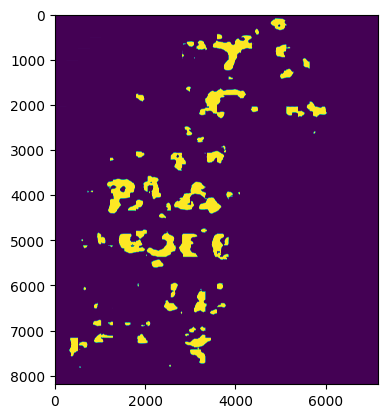

In [11]:

best_counter = 0
best_loss = np.inf
best_score = 0
optimizer = AdamW(model.parameters(), lr=CFG.lr)
swa_scheduler = SWALR(optimizer, swa_lr=0.05)
scheduler = get_scheduler(CFG, optimizer)
if CFG.valid_id == None:
    train_loader = load_data(CFG)
else:
    train_loader, valid_loader, valid_xyxys, valid_mask_gt = load_data(CFG)

for epoch in range(CFG.epochs):
    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)
    if epoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        # torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Update bn statistics for the swa_model at the end
    if CFG.valid_id != None:
        # eval
        avg_val_loss, mask_pred = valid_fn(
            valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

        scheduler_step(scheduler, avg_val_loss, epoch)

        best_dice, best_th, best_metrics = calc_fbeta(valid_mask_gt, mask_pred)

        # score = avg_val_loss
        score = best_dice

        wandb.log({"dice":best_dice, "avg_train_loss":avg_loss, "avg_val_loss":avg_val_loss, "ctp":best_metrics[0],
                   "cfp":best_metrics[1], "ctn":best_metrics[2], "cfn":best_metrics[3]})

        update_best = score > best_score
        if update_best:
            best_loss = avg_val_loss
            best_score = score
            best_counter = 0
            torch.save(model.module.state_dict(),
                    CFG.model_dir + f"{model_name}_best.pth")
        else:
            best_counter += 1
            if best_counter > 8:
                break
        torch.save(model.module.state_dict(),
                CFG.model_dir + f"{model_name}_final.pth")
        plt.imshow(mask_pred > best_th)
    else:        
        wandb.log({"avg_train_loss":avg_loss})
        scheduler_step(scheduler, avg_loss, epoch)
        if (epoch % 5) == 0:
            torch.save(model.module.state_dict(),
                CFG.model_dir + f"{model_name}_{epoch}_final.pth")
torch.optim.swa_utils.update_bn(train_loader, swa_model)
torch.save(swa_model.module.state_dict(),
    CFG.model_dir + f"{model_name}_final_swa.pth")
        
    